In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

import matplotlib.pyplot as plt
import tikzplotlib
import pylab
from mpl_toolkits.mplot3d import Axes3D
import plotly.figure_factory as ff
from scipy.spatial import Delaunay

In [39]:
# Create model for u
u_model = Sequential()
u_model.add(Dense(100, input_shape=[1], activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(100, activation='relu'))
u_model.add(Dense(1))

# Create model for lambda, lambda already defined :(
lamda_model = Sequential()
lamda_model.add(Dense(100, input_shape=[1], activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(100, activation='selu'))
lamda_model.add(Dense(1))

In [40]:
# Boundary function f(0)=0, f(1)=1
def bnd_f(x):
    y = np.heaviside(x-1, 1)
    return y

In [41]:
# u loss function
def u_loss(u_model, lamda_model, x):
    with tf.GradientTape() as t:
        t.watch(x)
        u = u_model(x, training=True)
        #print('u = ', u)
    du_dx = t.gradient(u,x)
    dirichlet_energy = tf.math.reduce_mean(tf.math.square(du_dx))
    
    mu = 10
    bound_loss = mu*(tf.square(u_model(tf.zeros(shape=[1,1]))-bnd_f(0))+tf.square(u_model(tf.ones(shape=[1,1]))-bnd_f(1)))
    #print(bnd_f(0),bnd_f(1))
    # Sample from boundary
    lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
    upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
    bnd_x = tf.transpose(tf.concat([lower_bound, upper_bound], 1))
    
    u_bnd = u_model(bnd_x)
    
    lamda = lamda_model(bnd_x,training=False) # x needs to be just on boundary
    lagrangian = lamda * (u_bnd - bnd_f(bnd_x))
    lagrange_loss = 100*tf.math.reduce_sum(lagrangian)
    
    loss = dirichlet_energy + lagrange_loss + bound_loss
    return loss

# u_loss(u_model, lamda_model, tf.zeros(shape=[1,1]))


# lambda loss function
def lamda_loss(u_model, lamda_model, x): # x needs to be just on boundary
    u_bnd = u_model(x)
    
    lamda = -1 * lamda_model(x,training=False) # x needs to be just on boundary
    lagrangian = lamda * (u_bnd - bnd_f(x))
    
    loss = tf.math.reduce_sum(lagrangian)
    return loss

In [43]:
def train_u(epochs):
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    minibatch_size = 100 # Number of points to be selected each iteration

    for epoch in range(epochs): 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            interior_pts = tf.random.uniform(shape=[1, minibatch_size-2]) # Interior points
            x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = u_model(x, training=True) # Estimate for u
                loss = u_loss(u_model, lamda_model, x) # Loss
            grads = t.gradient(loss, u_model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, u_model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

def train_lamda(epochs):
    optimizer = tf.keras.optimizers.Ftrl() # Fancy gradient decent
    train_loss_results = [] # For tracking loss during training
    iterations_per_epoch = 100
    
    for epoch in range(epochs): 
        epoch_loss_avg = tf.keras.metrics.Mean()
        for iteration in range(iterations_per_epoch):
            lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
            upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
            x = tf.transpose(tf.concat([lower_bound, upper_bound], 1)) # Actual training data
            with tf.GradientTape() as t:
                t.watch(x)
                #print(x)
                #f = u_model(x, training=True) # Estimate for u
                loss = lamda_loss(u_model, lamda_model, x) # Loss
            grads = t.gradient(loss, lamda_model.trainable_weights) # Find model gradients
            optimizer.apply_gradients(zip(grads, lamda_model.trainable_weights)) # Perform gradient decent
            epoch_loss_avg.update_state(loss) # Track loss
            # End training iteration
        train_loss_results.append(epoch_loss_avg.result())
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
        # End Epoch

def training_loop(total_iterations, u_epochs, lamda_epochs):
    for i in range(total_iterations):
        print("Iteration {:03d}:".format(i))
        
        print("Training lambda...")
        train_lamda(lamda_epochs)
                
        print("Training u...")
        train_u(u_epochs)
        


In [44]:
training_loop(10,5,1)

Iteration 000:
Training lambda...
Epoch 000: Loss: -0.053
Training u...
Epoch 000: Loss: 17.654
Epoch 001: Loss: 16.310
Epoch 002: Loss: 14.917
Epoch 003: Loss: 13.300
Epoch 004: Loss: 11.334
Iteration 001:
Training lambda...
Epoch 000: Loss: -0.010
Training u...
Epoch 000: Loss: 8.787
Epoch 001: Loss: 7.382
Epoch 002: Loss: 6.346
Epoch 003: Loss: 5.560
Epoch 004: Loss: 5.048
Iteration 002:
Training lambda...
Epoch 000: Loss: -0.000
Training u...
Epoch 000: Loss: 6.790
Epoch 001: Loss: 6.199
Epoch 002: Loss: 5.751
Epoch 003: Loss: 5.422
Epoch 004: Loss: 5.203
Iteration 003:
Training lambda...
Epoch 000: Loss: -0.002
Training u...
Epoch 000: Loss: 7.279
Epoch 001: Loss: 6.356
Epoch 002: Loss: 5.753
Epoch 003: Loss: 5.365
Epoch 004: Loss: 5.134
Iteration 004:
Training lambda...
Epoch 000: Loss: -0.000
Training u...
Epoch 000: Loss: 7.806
Epoch 001: Loss: 7.233
Epoch 002: Loss: 6.717
Epoch 003: Loss: 6.244
Epoch 004: Loss: 5.842
Iteration 005:
Training lambda...
Epoch 000: Loss: -0.004
Tr

0.31038829803466794


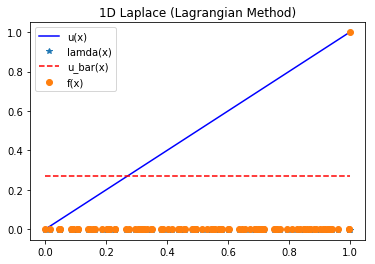

In [46]:
lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
x = tf.sort(tf.random.uniform(shape=[1,98])) # Interior points
test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
test_points = test_points_tensor.numpy()
u_bar = u_model(test_points_tensor, training=False).numpy()
lamda = lamda_model(test_points_tensor, training=False).numpy()
f = bnd_f(test_points)
x_actual = tf.sort(tf.random.uniform(shape=[1,1000]).numpy()) # Known solution
#print(test_points[0])
#print(x_actual[0])
#print(f[0])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('1D Laplace (Lagrangian Method)')
ax.plot(x_actual[0],x_actual[0], label='u(x)', color='blue')
ax.plot(test_points, lamda, '*', label='lamda(x)')
ax.plot(test_points, u_bar, 'r--', label='u_bar(x)')
ax.plot(test_points, f, 'o', label='f(x)')
ax.legend()
# ax.set_aspect('equal','box')

tikzplotlib.save("1d_laplace_lagrangian.tex")

average_error = np.sum(abs(u_bar-test_points))/len(u_bar)
print(average_error)